In [2]:
%pip install pandas
%pip install darts

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from darts import TimeSeries
from darts.utils.model_selection import train_test_split
import numpy as np
import warnings

warnings.filterwarnings("ignore")


random_state = 42
np.random.seed(random_state)

In [4]:
def RemoveOutliers(df, column):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [5]:
purchase_orders = pd.read_csv("./data/kernel/purchase_orders.csv")
purchase_orders = purchase_orders[purchase_orders["status"] == "Closed"]

purchase_orders["delivery_date"] = (
    pd.to_datetime(purchase_orders["delivery_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders["created_date_time"] = (
    pd.to_datetime(purchase_orders["created_date_time"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders.head()

,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,1,1,-14.0,2003-05-11,91900143,1,2003-05-12,2004-06-15 06:16:18.0000000 +00:00,NaN,NaN,2,Closed
1,22,1,23880.0,2003-05-26,91900160,1,2003-05-27,2012-06-29 09:41:13.0000000 +00:00,NaN,NaN,2,Closed
2,41,1,0.0,2004-03-07,91900143,1,2004-03-08,2012-07-04 13:51:02.0000000 +00:00,NaN,NaN,2,Closed
3,61,1,0.0,2004-03-09,91900143,1,2004-03-10,2012-07-04 13:50:59.0000000 +00:00,NaN,NaN,2,Closed
4,141,10,25000.0,2004-10-27,91900143,1,2004-10-22,2012-07-04 13:50:55.0000000 +00:00,NaN,NaN,2,Closed


In [6]:
receivals = pd.read_csv("data/kernel/receivals.csv")
len(receivals)

receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]
receivals = receivals.dropna(subset=["rm_id"])
receivals["rm_id"] = receivals["rm_id"].astype(int)


print("Drop rows where net_weight is NaN or <= 0:", len(receivals))

receivals["date_arrival"] = (
    pd.to_datetime(receivals["date_arrival"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

receivals = receivals[receivals["date_arrival"] > pd.Timestamp("2020-01-01")]

receivals = receivals.merge(
    purchase_orders,
    how="left",
    on=["purchase_order_id", "purchase_order_item_no"],
)


daily_receivals = (
    receivals.groupby(["rm_id", "date_arrival"], as_index=False)
    .agg(
        net_weight_sum=("net_weight", "sum"),
        total_order_qty=("quantity", "sum"),
        avg_order_qty=("quantity", "mean"),
        num_orders=("purchase_order_id", "count"),
    )
    .rename(columns={"date_arrival": "date", "net_weight_sum": "net_weight"})
    .sort_values(["rm_id", "date"])
)
print(len(daily_receivals))


stats = daily_receivals.groupby("rm_id").agg(
    last_delivery=("date", "max"),
    total_deliveries=("date", "count"),  # number of delivery-days
)
cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

rare_rm_id = stats.index[
    (stats["last_delivery"] <= cutoff) | (stats["total_deliveries"] <= 23)
]

print(
    f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}"
)
# I remove rare_rm_id
daily_receivals = daily_receivals[
    ~daily_receivals["rm_id"].isin(rare_rm_id)
].reset_index(drop=True)

print("Length of daily_receivals after filtering rare rm_id:", len(daily_receivals))

daily_receivals = RemoveOutliers(daily_receivals, "net_weight")
print("Length of daily_receivals after removing outliers:", len(daily_receivals))


Drop rows where net_weight is NaN or <= 0: 122383
13663
We don't have enough information to forecast the following rm_id :
Index([2121, 2123, 2138, 2147, 2161, 2284, 2401, 2402, 2482, 2521, 2561, 2601,
       2742, 2821, 3022, 3101, 3144, 3162, 3201, 3222, 3241, 3381, 3461, 3481,
       3501, 3541, 3581, 3601, 3621, 3701, 3762, 3802, 3821, 3841, 3883, 3921,
       3941, 4021, 4044, 4081, 4101, 4161, 4263, 4302, 4343, 4381, 4401, 4441,
       4443, 4461, 4462, 4463, 4481, 4501],
      dtype='int64', name='rm_id')
Length of daily_receivals after filtering rare rm_id: 13344
Length of daily_receivals after removing outliers: 12671


In [7]:
daily_receivals.head()

,rm_id,date,net_weight,total_order_qty,avg_order_qty,num_orders
0,2124,2020-03-04,2160.0,0.0,NaN,1
1,2124,2020-03-09,2160.0,0.0,NaN,1
2,2124,2020-05-13,4320.0,0.0,NaN,1
3,2124,2020-07-09,4320.0,0.0,NaN,1
4,2124,2020-10-06,4320.0,0.0,NaN,1


In [8]:
# # build full index. one timestamp for each day for each rm_id
# full_start = daily_receivals["date"].min()
# print("Full start date:", full_start)
# full_end = pd.Timestamp("2024-12-31")
# rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
# calendar = pd.date_range(full_start, full_end, freq="D", name="date")
# full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id", "date"])
# print(len(full_idx))
# daily_receivals = (
#     daily_receivals.set_index(["rm_id", "date"])
#     .reindex(full_idx, fill_value=0)
#     .reset_index()
# )

# print(len(daily_receivals))

In [9]:
# add rolling count features: number of delivery-days (net_weight>0) in last 7/30 days
daily_receivals = daily_receivals.sort_values(["rm_id", "date"])
daily_receivals["deliv_flag"] = (daily_receivals["net_weight"] > 0).astype(int)

for w in (7, 30):
    col = f"num_deliveries_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["deliv_flag"]
        .rolling(window=w, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
        .astype(int)
    )

# add rolling cumsum features: total net_weight in last 7/30 days
for w in (7, 30):
    col = f"total_net_weight_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["net_weight"]
        .rolling(window=w, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

# total ordered_qty in last 7/30 days
for w in (7, 30):
    col = f"total_order_qty_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["total_order_qty"]
        .rolling(window=w, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

# average ordered_qty in last 7/30 days
for w in (7, 30):
    col = f"avg_order_qty_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["avg_order_qty"]
        .rolling(window=w, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# std ordered_qty in last 7/30 days
for w in (7, 30):
    col = f"std_order_qty_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["avg_order_qty"]
        .rolling(window=w, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    ).fillna(0)

# num orders in last 7/30 days
for w in (7, 30):
    col = f"num_orders_last_{w}d"
    daily_receivals[col] = (
        daily_receivals.groupby("rm_id")["num_orders"]
        .rolling(window=w, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

## Convert to TimeSeries

In [10]:
series_lst = TimeSeries.from_group_dataframe(
    daily_receivals,
    "rm_id",
    "date",
    "net_weight",
    freq="D",
    fill_missing_dates=True,
    fillna_value=0.0,
)
# series_lst = [ts.astype(np.float32) for ts in series_lst]
print(len(series_lst), len(series_lst[0]))

39 1613


In [11]:
from darts.dataprocessing.transformers import InvertibleMapper

covariate_cols = [
    "num_deliveries_last_7d",
    "num_deliveries_last_30d",
    "total_net_weight_last_7d",
    "total_net_weight_last_30d",
    "total_order_qty_last_7d",
    "total_order_qty_last_30d",
    "avg_order_qty_last_7d",
    "avg_order_qty_last_30d",
    "num_orders_last_7d",
    "num_orders_last_30d",
    "std_order_qty_last_7d",
    "std_order_qty_last_30d",
]

covariate_series = TimeSeries.from_group_dataframe(
    daily_receivals,
    "rm_id",
    "date",
    covariate_cols,
    freq="D",
    fill_missing_dates=True,
    fillna_value=0.0,
)

# log_transformer = InvertibleMapper(lambda x: np.log1p(x), lambda x: np.expm1(x))
# covariate_series = log_transformer.transform(covariate_series)

print(len(covariate_series), len(covariate_series[0]))

39 1613


In [12]:
from darts.dataprocessing.transformers import WindowTransformer

# Extract mean of last seven days from series
transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 7}, treat_na=0
)
mean_7_days = transformer.transform(series_lst)

transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 30}, treat_na=0
)
mean_30_days = transformer.transform(series_lst)

transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 90}, treat_na=0
)
mean_90_days = transformer.transform(series_lst)

print(len(mean_7_days), len(mean_7_days[0]))

39 1613


In [13]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode


trend_and_seasonality = []
for i, series in enumerate(series_lst):
    # Extract trend and seasonal components
    if len(series) < 2 * 7:
        print(f"Series {i} is too short for trend/seasonality extraction.")
        # Platzhalter erstellen
        trend_placeholder = TimeSeries.from_times_and_values(
            series.time_index, np.zeros((len(series), 1)), columns=["trend"]
        )
        seasonal_placeholder = TimeSeries.from_times_and_values(
            series.time_index, np.zeros((len(series), 1)), columns=["seasonal"]
        )
        trend_and_seasonality.append((trend_placeholder, seasonal_placeholder))
        continue

    trend, seasonal = extract_trend_and_seasonality(
        series, freq=7, model=ModelMode.ADDITIVE
    )
    trend = trend.with_columns_renamed("net_weight", "trend")
    seasonal = seasonal.with_columns_renamed("net_weight", "seasonal")

    trend_and_seasonality.append((trend, seasonal))

print(len(trend_and_seasonality), len(trend_and_seasonality[0][0]))

39 1613


In [14]:
from darts import concatenate

past_covariates = []
for i, series in enumerate(series_lst):
    trend = trend_and_seasonality[i][0]
    seasonal = trend_and_seasonality[i][1]

    post_cov = concatenate(
        [
            # mean_7_days[i],
            # mean_30_days[i],
            # mean_90_days[i],
            # covariate_series[i],
            trend,
            seasonal,
        ],
        axis=1,
        ignore_static_covariates=True,
    )
    past_covariates.append(post_cov)


print(len(past_covariates), len(past_covariates[0]))

39 1613


In [15]:
past_covariates[0].columns

Index(['trend', 'seasonal'], dtype='object')

In [16]:
# Function to check covariates
def check_covariates(df, covariate_cols):
    summary = df[covariate_cols].describe().T
    summary["nonzero_count"] = (df[covariate_cols] != 0).sum()
    summary["nonzero_ratio"] = (df[covariate_cols] != 0).mean()
    summary["std"] = df[covariate_cols].std()
    return summary


display(check_covariates(daily_receivals, covariate_cols))
transformed = daily_receivals[covariate_cols].copy().apply(lambda x: np.log1p(x))
check_covariates(transformed, covariate_cols)

,count,mean,std,min,25%,50%,75%,max,nonzero_count,nonzero_ratio
num_deliveries_last_7d,12671.0,6.935364e+00,5.252927e-01,1.0,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,12671,1.000000
num_deliveries_last_30d,12671.0,2.866498e+01,4.953635e+00,1.0,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,12671,1.000000
total_net_weight_last_7d,12671.0,1.822624e+05,1.470421e+05,1100.0,5.231100e+04,1.724600e+05,2.758410e+05,7.168630e+05,12671,1.000000
total_net_weight_last_30d,12671.0,7.557089e+05,6.090875e+05,1100.0,2.220795e+05,7.472500e+05,1.169928e+06,2.683460e+06,12671,1.000000
total_order_qty_last_7d,12671.0,5.592763e+06,1.182952e+07,0.0,5.700000e+05,1.125000e+06,3.000000e+06,8.028500e+07,12586,0.993292
total_order_qty_last_30d,12671.0,2.329325e+07,4.883709e+07,0.0,2.456000e+06,4.950000e+06,1.270000e+07,2.860700e+08,12629,0.996685
avg_order_qty_last_7d,12586.0,2.597125e+05,3.527438e+05,5000.0,6.142857e+04,1.142857e+05,2.857143e+05,2.253231e+06,12671,1.000000
avg_order_qty_last_30d,12629.0,2.581698e+05,3.459368e+05,7400.0,6.288889e+04,1.189556e+05,2.766667e+05,1.948532e+06,12671,1.000000
num_orders_last_7d,12671.0,1.357565e+01,8.971371e+00,1.0,8.000000e+00,1.000000e+01,1.500000e+01,5.800000e+01,12671,1.000000
num_orders_last_30d,12671.0,5.642799e+01,3.724445e+01,1.0,3.500000e+01,4.300000e+01,6.100000e+01,2.090000e+02,12671,1.000000


,count,mean,std,min,25%,50%,75%,max,nonzero_count,nonzero_ratio
num_deliveries_last_7d,12671.0,2.067279,0.105818,0.693147,2.079442,2.079442,2.079442,2.079442,12671,1.000000
num_deliveries_last_30d,12671.0,3.357395,0.323902,0.693147,3.433987,3.433987,3.433987,3.433987,12671,1.000000
total_net_weight_last_7d,12671.0,11.664790,1.078814,7.003974,10.864981,12.057926,12.527584,13.482641,12671,1.000000
total_net_weight_last_30d,12671.0,13.089023,1.070919,7.003974,12.310795,13.524156,13.972454,14.802618,12671,1.000000
total_order_qty_last_7d,12671.0,14.113224,1.917218,0.000000,13.253393,13.933294,14.914123,18.201093,12586,0.993292
total_order_qty_last_30d,12671.0,15.582587,1.798069,0.000000,14.714045,15.414898,16.357113,19.471747,12629,0.996685
avg_order_qty_last_7d,12586.0,11.769325,1.187788,8.517393,11.025647,11.646466,12.562751,14.627876,12671,1.000000
avg_order_qty_last_30d,12629.0,11.791966,1.156012,8.909370,11.049141,11.686514,12.530572,14.482587,12671,1.000000
num_orders_last_7d,12671.0,2.545061,0.484205,0.693147,2.197225,2.397895,2.772589,4.077537,12671,1.000000
num_orders_last_30d,12671.0,3.881268,0.591031,0.693147,3.583519,3.784190,4.127134,5.347108,12671,1.000000


In [17]:
past_covariates[0].to_dataframe()

,trend,seasonal
date,,
2020-03-04,705.306122,13.577096
2020-03-05,639.183673,-32.015447
2020-03-06,573.061224,58.775435
2020-03-07,617.142857,-69.140172
2020-03-08,308.571429,-67.798557
...,...,...
2024-07-29,0.000000,-25.537687
2024-07-30,1234.285714,122.139331
2024-07-31,0.000000,13.577096


## Split train test

In [18]:
test_size = 0.2

train_lst, val_lst = train_test_split(series_lst, axis=1, test_size=test_size)
train_past_covariates, val_past_covariates = train_test_split(
    past_covariates, axis=1, test_size=test_size
)

print("Num series in training set:", len(train_lst))
print("Num series in validation set:", len(val_lst))
print("Num past covariates in training set:", len(train_past_covariates))
print("Num past covariates in validation set:", len(val_past_covariates))
print("Num elements in train series:", len(train_lst[0]))
print("Num elements in past covariate series:", len(train_past_covariates[0]))
print("Num elements in val series:", len(val_lst[0]))
print("Num elements in val past covariate series:", len(val_past_covariates[0]))


Num series in training set: 39
Num series in validation set: 39
Num past covariates in training set: 39
Num past covariates in validation set: 39
Num elements in train series: 1291
Num elements in past covariate series: 1291
Num elements in val series: 322
Num elements in val past covariate series: 322


## Scale

In [19]:
from darts.dataprocessing.transformers import Scaler, InvertibleMapper
from darts.dataprocessing.pipeline import Pipeline

log_transformer = InvertibleMapper(lambda x: np.log1p(x), lambda x: np.expm1(x))

# scale the past covariates
# scaler_part_covs = Scaler(global_fit=True)
# past_cov_pipeline = Pipeline([scaler_part_covs])
past_cov_pipeline = Pipeline([])
train_past_covariates = past_cov_pipeline.fit_transform(train_past_covariates)
val_past_covariates = past_cov_pipeline.transform(val_past_covariates)
past_covariates = past_cov_pipeline.transform(past_covariates)

pipeline = Pipeline([])
# scaler = Scaler()
# pipeline = Pipeline([log_transformer, scaler])
# pipeline = Pipeline([scaler])
train_lst_scaled = pipeline.fit_transform(train_lst)
val_lst_scaled = pipeline.transform(val_lst)
series_lst_scaled = pipeline.transform(series_lst)

Empty pipeline created
Empty pipeline created


## Train model

In [20]:
from darts.models import XGBModel, NBEATSModel, RNNModel
from darts.models.forecasting.xgboost import xgb_quantile_loss
from darts.dataprocessing.transformers import Mapper

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from kaggle_metric import quantile_error
from darts.metrics.metrics import r2_score, mse


def quantile_loss(y_true, y_pred):
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.clip(min=0)
    return xgb_quantile_loss(y_true, y_pred, quantile=0.2)


# Quantile Loss als Eval Metric
def quantile_eval(y_true, y_pred):
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.clip(min=0)
    return quantile_error(y_true, y_pred)


encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["dayofweek", "year", "quarter", "weekofyear"]},
    "transformer": Scaler(),
}

min_value_mapper = Mapper(lambda x: np.where(x < 0.0, 0, x))


def predict_val(model):
    pred = model.predict(
        len(val_lst[0]), train_lst_scaled, past_covariates=past_covariates
    )
    pred = min_value_mapper.transform(pred)
    pred = pipeline.inverse_transform(pred)

    error = []
    for ts, pred_ts in zip(val_lst, pred):
        err = quantile_error(ts.values(), pred_ts.values())
        error.append(err)
    print("Quantile Error on validation set:", np.mean(error))
    print("R2 Score on validation set:", r2_score(val_lst, pred))
    mse_score = mse(val_lst, pred)
    print("MSE on validation set:", np.mean(mse_score), mse_score)

    return pred


def eval_model(model):
    model.fit(
        train_lst_scaled,
        val_series=val_lst_scaled,
        past_covariates=train_past_covariates,
        val_past_covariates=val_past_covariates,
        verbose=True,
    )
    return predict_val(model)

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


In [21]:
import matplotlib.pyplot as plt


def plot_predictions(pred):
    # Number of samples to plot
    n = 15  # or whatever you need
    num_samples = min(n, len(train_lst), len(val_lst), len(pred))

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 3))

    # Ensure axes is always a list
    if num_samples == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        # If these are pandas Series/DataFrames, we can call .plot() directly
        train_lst[i].plot(ax=ax, label="Train")
        val_lst[i].plot(ax=ax, label="Validation")
        pred[i].plot(ax=ax, label="Prediction", alpha=0.7)

        ax.set_title(f"Sample {i}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

### Clustering xgb

In [22]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# inertia = []
# K_range = range(1, 15)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=random_state)
#     kmeans.fit(
#         [ts.values().reshape(-1) for ts in past_covariates]
#     )  # z.B. Feature-Matrix aus TS
#     inertia.append(kmeans.inertia_)

# plt.figure(figsize=(8, 5))
# plt.plot(K_range, inertia, "o-")
# plt.xlabel("Anzahl Cluster k")
# plt.ylabel("Summe der quadratischen Abstände (Inertia)")
# plt.title("Elbow-Methode zur Wahl von k")
# plt.show()


In [23]:
# n = 3
# kmeans = KMeans(n_clusters=n, random_state=random_state)
# labels = kmeans.fit_predict(
#     [ts.values().reshape(-1) for ts in past_covariates]
# )  # z.B. Feature-Matrix aus TS

In [24]:
# train_clusters = {i: [] for i in range(n)}
# val_clusters = {i: [] for i in range(n)}
# for train_ts, val_ts, label in zip(train_lst_scaled, val_lst_scaled, labels):
#     train_clusters[label].append(train_ts)
#     val_clusters[label].append(val_ts)

# for cluster_id in range(n):
#     print(len(train_clusters[cluster_id]))

In [25]:
# cluster_models = {}
# for cluster_id, ts_list in train_clusters.items():
#     print(f"Evaluating cluster {cluster_id} with {len(ts_list)} time series.")
#     if len(ts_list) == 0:
#         print(f"No time series in cluster {cluster_id}, skipping.")
#         continue
#     cluster_train_lst = ts_list
#     cluster_val_lst = val_clusters[cluster_id]

#     xgb_model = XGBModel(
#         lags=32,
#         lags_past_covariates=24,
#         lags_future_covariates=[0, 1],
#         output_chunk_length=150,
#         add_encoders=encoders,
#         # objective=quantile_loss,
#         eval_metric=quantile_eval,
#         n_estimators=100,
#         random_state=random_state,
#     )

#     xgb_model.fit(
#         cluster_train_lst,
#         val_series=cluster_val_lst,
#         past_covariates=train_past_covariates,
#         val_past_covariates=val_past_covariates,
#         verbose=True,
#     )
#     cluster_models[cluster_id] = xgb_model

#     # pred = xgb_model.predict(len(cluster_val_lst[0]), cluster_train_lst)
#     # pred = pipeline.inverse_transform(pred)
#     # pred = min_value_mapper.transform(pred)

#     # plot_predictions(pred)

## Naive model

RMSE: 4379.047568028683
R2 Score: -0.044099717135498206


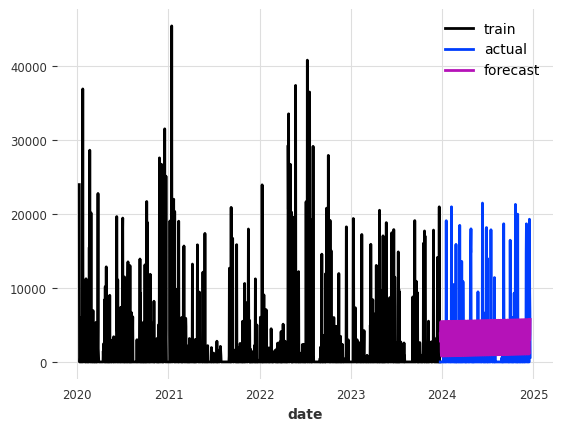

In [26]:
from darts.models import ExponentialSmoothing
from darts.metrics import rmse, r2_score

n = 12
model = ExponentialSmoothing()
model.fit(train_lst_scaled[n])

# Vorhersage für die Länge des Validation Sets
pred = model.predict(len(val_lst_scaled[n]))

# Evaluation
print("RMSE:", rmse(val_lst_scaled[n], pred))
print("R2 Score:", r2_score(val_lst_scaled[n], pred))

# Plot
import matplotlib.pyplot as plt

train_lst_scaled[n].plot(label="train")
val_lst_scaled[n].plot(label="actual")
pred.plot(label="forecast")
plt.legend()
plt.show()

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


RMSE: 3.7493196210476915e-10
R2 Score: 1.0


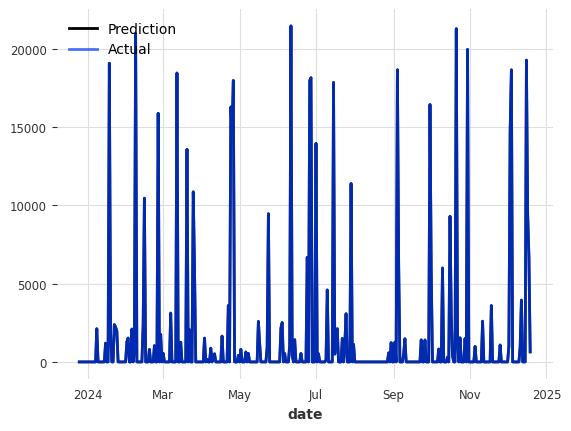

In [27]:
from darts.models import LinearRegressionModel

linear_model = LinearRegressionModel(
    lags=32,
    lags_past_covariates=24,
    output_chunk_length=1,
    random_state=random_state,
)
n = 12
linear_model.fit(train_lst_scaled[n], past_covariates=train_past_covariates[n])
pred = linear_model.predict(
    len(val_lst[n]), train_lst_scaled[n], past_covariates=past_covariates[n]
)

# Evaluation
print("RMSE:", rmse(val_lst_scaled[n], pred))
print("R2 Score:", r2_score(val_lst_scaled[n], pred))

pred.plot(label="Prediction")
val_lst_scaled[n].plot(label="Actual", alpha=0.7)
plt.legend()
plt.show()

### XGB

In [28]:
# n = 1
# for i in range(len(train_lst_scaled)):
#     xgb_model = XGBModel(
#         lags=32,
#         lags_past_covariates=6,
#         output_chunk_length=1,
#         early_stopping_rounds=50,
#         random_state=random_state,
#         n_jobs=-1,
#     )

#     xgb_model.fit(
#         train_lst_scaled[i],
#         val_series=val_lst_scaled[i],
#         past_covariates=train_past_covariates[i],
#         val_past_covariates=val_past_covariates[i],
#         verbose=False,
#     )

#     # Evaluation
#     print("RMSE:", rmse(val_lst_scaled[i], pred))
#     print("R2 Score:", r2_score(val_lst_scaled[i], pred))

#     preds = xgb_model.predict(
#         len(val_lst_scaled[i]),
#         train_lst_scaled[i],
#         past_covariates=past_covariates[i],
#     )

#     train_lst_scaled[i].plot(label="Train")
#     preds.plot(label="XGB Prediction")
#     val_lst_scaled[i].plot(label="Actual", alpha=0.7)
#     plt.legend()
#     plt.show()

In [29]:
# n = 1
# xgb_model = XGBModel(
#     lags=32,
#     lags_past_covariates=6,
#     # lags_future_covariates=[0, 1],
#     output_chunk_length=1,
#     # add_encoders=encoders,
#     early_stopping_rounds=50,
#     # objective='reg:quantileerror',
#     # quantile_alpha=0.2,
#     # eval_metric=quantile_eval,
#     # n_estimators=1000,
#     random_state=random_state,
#     # multi_models=True,
#     n_jobs=-1,
#     # tree_method="hist",  # Faster for large datasets
# )


# xgb_model.fit(
#     train_lst_scaled[n],
#     val_series=val_lst_scaled[n],
#     past_covariates=train_past_covariates[n],
#     val_past_covariates=val_past_covariates[n],
#     verbose=True,
# )

# # Evaluation
# print("RMSE:", rmse(val_lst_scaled[n], pred))
# print("R2 Score:", r2_score(val_lst_scaled[n], pred))

# preds = xgb_model.predict(
#     len(val_lst_scaled[n]),
#     train_lst_scaled[n],
#     past_covariates=past_covariates[n],
# )

# train_lst_scaled[n].plot(label="Train")
# preds.plot(label="XGB Prediction")
# val_lst_scaled[n].plot(label="Actual", alpha=0.7)
# plt.legend()
# plt.show()

### Torch config

In [30]:
# import torch
# import torch.nn as nn
# from darts.utils.callbacks import TFMProgressBar


# class QuantileLoss(nn.Module):
#     def __init__(self, quantile: float = 0.2):
#         super().__init__()
#         self.q = quantile

#     def forward(self, preds, target):
#         diff = target - preds
#         loss = torch.where(diff >= 0, self.q * diff, (1 - self.q) * -diff)
#         return loss.mean()


# my_stopper = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     min_delta=0.05,
#     mode="min",
# )

# pl_trainer_kwargs = {
#     "callbacks": [my_stopper, TFMProgressBar(enable_train_bar_only=True)],
#     "accelerator": "cpu",
#     "max_epochs": 20,
# }

### TFT

In [31]:
# tft_model = TFTModel(
#     input_chunk_length=24,
#     output_chunk_length=12,
#     add_encoders=encoders,
#     loss_fn=QuantileLoss(quantile=0.2),
#     random_state=random_state,
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

### RNN 

In [32]:
# rnn_model = RNNModel(
#     input_chunk_length=14,
#     model="LSTM",
#     hidden_dim=20,
#     n_rnn_layers=2,
#     dropout=0.1,
#     n_epochs=50,
#     batch_size=32,
#     loss_fn=QuantileLoss(quantile=0.2),
#     optimizer_kwargs={"lr": 1e-3},
#     random_state=random_state,
#     save_checkpoints=True,
#     add_encoders=encoders,
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

# rnn_model.fit(train_lst_scaled, val_series=val_lst_scaled)
# preds_rnn = predict_val(rnn_model)
# plot_predictions(preds_rnn)

### NBeats

In [33]:
train_lst_scaled[n]

<TimeSeries (date: 1445, component: 1, sample: 1)> Size: 12kB
array([[[23952.]],

       [[    0.]],

       [[    0.]],

       ...,

       [[    0.]],

       [[    0.]],

       [[    0.]]], shape=(1445, 1, 1))
Coordinates:
  * date       (date) datetime64[ns] 12kB 2020-01-10 2020-01-11 ... 2023-12-24
  * component  (component) object 8B 'net_weight'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   rm_id\nnet_weight         2144.0
    hierarchy:          None
    metadata:           None

In [ ]:
from darts.utils.callbacks import TFMProgressBar

model_dict = {}
for n in range(len(train_lst_scaled)):
    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode="min",
    )

    pl_trainer_kwargs = {
        "callbacks": [my_stopper, TFMProgressBar(enable_train_bar_only=True)],
        "accelerator": "cpu",
        "max_epochs": 50,
    }
    model_name = f"nbeats_run_{n}"
    model_nbeats = NBEATSModel(
        input_chunk_length=23,
        output_chunk_length=1,
        generic_architecture=True,
        nr_epochs_val_period=1,
        num_stacks=5,
        batch_size=128,
        random_state=random_state,
        model_name=model_name,
        save_checkpoints=True,
        force_reset=True,
        dropout=0.3,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )

    model_nbeats.fit(
        train_lst_scaled[n],
        val_series=val_lst_scaled[n],
        past_covariates=train_past_covariates[n],
        val_past_covariates=val_past_covariates[n],
        verbose=True,
    )
    model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)
    model_dict[n] = model_nbeats

    # Evaluation
    print("RMSE:", rmse(val_lst_scaled[n], pred))
    print("R2 Score:", r2_score(val_lst_scaled[n], pred))

    pred = model_nbeats.predict(
        len(val_lst_scaled[n]),
        train_lst_scaled[n],
        past_covariates=past_covariates[n],
    )

    train_lst_scaled[n].plot(label="Train")
    pred.plot(label="NBEATS Prediction")
    val_lst_scaled[n].plot(label="Actual", alpha=0.7)
    plt.legend()
    plt.show()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 1803.9430225782594
R2 Score: -5.557973577231134


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 1723.6251466291608
R2 Score: -0.08379938689908051


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 3012.044713700886
R2 Score: -0.762566998632245


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 37083.194626187746
R2 Score: -0.39334214094278086


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 31293.9484830417
R2 Score: -39.99156294514917


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 4137.347877805726
R2 Score: -0.7186371142684904


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 3040.638593114394
R2 Score: -2.274700392495046


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 9371.954334996708
R2 Score: -0.20579541465440054


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 8880.159377645507
R2 Score: -1.3316956158881887


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 15130.473024272842
R2 Score: -0.041231426958107775


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 14919.218960860358
R2 Score: -5.66126720758209


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 6770.143123868399
R2 Score: -12.364107280776018


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 4452.726766868485
R2 Score: 0.04946407854492896


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 4111.523727509364
R2 Score: -1.6206347303905373


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: nan
R2 Score: nan


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 56999.89549981289
R2 Score: -1.9348469995797024


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: nan
R2 Score: nan


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 6276.485280249211
R2 Score: -0.024261325972997128


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 19853.16876359768
R2 Score: -0.5772981745101902


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 15074.289076044217
R2 Score: -0.13581354327746964


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 14034.661932674468
R2 Score: 0.09386136000631784


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 17816.510292805156
R2 Score: 0.26397274484450683


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 19336.7079262006
R2 Score: -0.005879698688069812


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 25250.426413917558
R2 Score: -23.784590474487445


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: nan
R2 Score: nan


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.1 M     Trainable params
1.7 K     Non-trainable params
1.1 M     Total params
4.366     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 20684.19843043241
R2 Score: -1.3136054119867082


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 16900.557447153868
R2 Score: -5.849789565641274


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 4229.616032514988
R2 Score: -0.13213164639082042


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: nan
R2 Score: nan


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 29798.745644897976
R2 Score: -0.020471591793232102


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  |

RMSE: 28041.851599401234
R2 Score: -2.8093612261137695


Training: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RMSE: 13857.995821500968
R2 Score: -1.3780992479748102


In [36]:
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

end_date = pd.Timestamp("2025-05-31")
min_value_mapper = Mapper(lambda x: np.where(x < 0.0, 0, x))


def extract_past_covs(series):
    trend, seasonal = extract_trend_and_seasonality(
        series, freq=7, model=ModelMode.ADDITIVE
    )
    trend = trend.with_columns_renamed("net_weight", "trend")
    seasonal = seasonal.with_columns_renamed("net_weight", "seasonal")
    post_cov = concatenate(
        [
            trend,
            seasonal,
        ],
        axis=1,
        ignore_static_covariates=True,
    )
    return post_cov


final_predictions = []
for key, model in model_dict.items():
    last_index = series_lst_scaled[key].time_index[-1]
    n_steps = (end_date - last_index).days // 1  # assuming daily frequency
    print(
        f"Model {key}: generating {n_steps} predictions from {last_index} - {end_date}"
    )

    model = model_dict[key]
    series = series_lst_scaled[key].copy()
    covs = past_covariates[key].copy()

    for i in range(n_steps):
        pred = model.predict(1, series, past_covariates=covs)
        pred = min_value_mapper.transform(pred)

        # update series_lst_scaled and covariates with the new prediction
        series = series.append(pred)
        covs = extract_past_covs(series)

    df = series[-150:].cumsum().to_dataframe()
    rm_id = series.static_covariates["rm_id"].values[0]
    df["rm_id"] = rm_id
    df["end_date"] = df.index
    final_predictions.append(df)

df_final = pd.concat(final_predictions)

Model 0: generating 302 predictions from 2024-08-02 00:00:00 - 2025-05-31 00:00:00
Model 1: generating 180 predictions from 2024-12-02 00:00:00 - 2025-05-31 00:00:00
Model 2: generating 163 predictions from 2024-12-19 00:00:00 - 2025-05-31 00:00:00
Model 3: generating 163 predictions from 2024-12-19 00:00:00 - 2025-05-31 00:00:00
Model 4: generating 171 predictions from 2024-12-11 00:00:00 - 2025-05-31 00:00:00
Model 5: generating 165 predictions from 2024-12-17 00:00:00 - 2025-05-31 00:00:00
Model 6: generating 190 predictions from 2024-11-22 00:00:00 - 2025-05-31 00:00:00
Model 7: generating 163 predictions from 2024-12-19 00:00:00 - 2025-05-31 00:00:00
Model 8: generating 164 predictions from 2024-12-18 00:00:00 - 2025-05-31 00:00:00
Model 9: generating 270 predictions from 2024-09-03 00:00:00 - 2025-05-31 00:00:00
Model 10: generating 163 predictions from 2024-12-19 00:00:00 - 2025-05-31 00:00:00
Model 11: generating 163 predictions from 2024-12-19 00:00:00 - 2025-05-31 00:00:00
Mo

rm_id
2124.0    Axes(0.125,0.11;0.775x0.77)
2125.0    Axes(0.125,0.11;0.775x0.77)
2129.0    Axes(0.125,0.11;0.775x0.77)
2130.0    Axes(0.125,0.11;0.775x0.77)
2131.0    Axes(0.125,0.11;0.775x0.77)
2132.0    Axes(0.125,0.11;0.775x0.77)
2133.0    Axes(0.125,0.11;0.775x0.77)
2134.0    Axes(0.125,0.11;0.775x0.77)
2135.0    Axes(0.125,0.11;0.775x0.77)
2140.0    Axes(0.125,0.11;0.775x0.77)
2142.0    Axes(0.125,0.11;0.775x0.77)
2143.0    Axes(0.125,0.11;0.775x0.77)
2144.0    Axes(0.125,0.11;0.775x0.77)
2145.0    Axes(0.125,0.11;0.775x0.77)
2153.0    Axes(0.125,0.11;0.775x0.77)
2160.0    Axes(0.125,0.11;0.775x0.77)
2741.0    Axes(0.125,0.11;0.775x0.77)
2761.0    Axes(0.125,0.11;0.775x0.77)
2981.0    Axes(0.125,0.11;0.775x0.77)
3005.0    Axes(0.125,0.11;0.775x0.77)
3121.0    Axes(0.125,0.11;0.775x0.77)
3122.0    Axes(0.125,0.11;0.775x0.77)
3123.0    Axes(0.125,0.11;0.775x0.77)
3124.0    Axes(0.125,0.11;0.775x0.77)
3125.0    Axes(0.125,0.11;0.775x0.77)
3126.0    Axes(0.125,0.11;0.775x0.77)
3142.0

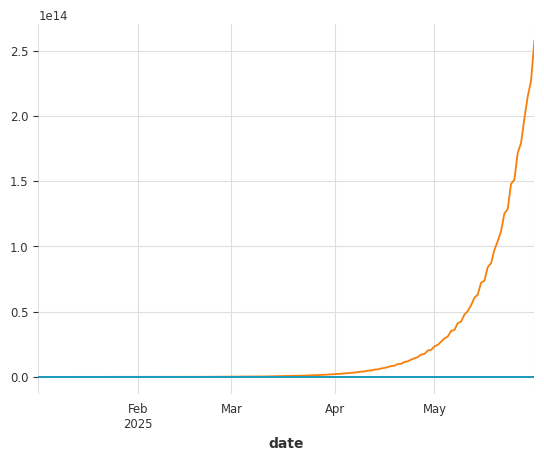

In [ ]:
df_final.groupby("rm_id")["net_weight"].plot()

In [39]:
prediction_mapping = pd.read_csv("./data/prediction_mapping.csv")
prediction_mapping["forecast_start_date"] = (
    pd.to_datetime(prediction_mapping["forecast_start_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)
prediction_mapping["forecast_end_date"] = (
    pd.to_datetime(prediction_mapping["forecast_end_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

prediction_mapping = prediction_mapping.sort_values(["rm_id", "forecast_end_date"])
start_date = pd.Timestamp("2025-01-01")

df_submission = (
    prediction_mapping.merge(
        df_final,
        left_on=["rm_id", "forecast_end_date"],
        right_on=["rm_id", "end_date"],
        how="left",
    )
    .rename(columns={"net_weight": "predicted_weight"})
    .sort_values("ID")
)
df_submission.fillna(0, inplace=True)
df_submission[["ID", "predicted_weight"]].to_csv("submission.csv", index=False)

In [ ]:
df_submission[df_submission["predicted_weight"] > 0]

## Write predictions to file


In [ ]:
# def generate_forecasts(model, steps):
#     forecasts = model.predict(steps, series_lst_scaled, past_covariates=past_covariates)
#     forecasts = min_value_mapper.transform(forecasts)
#     forecasts = pipeline.inverse_transform(forecasts)
#     forecasts_cum = [ts.cumsum() for ts in forecasts]
#     return forecasts, forecasts_cum


# print("---------------XGB---------------")
# forecasts, forecasts_cum = generate_forecasts(xgb_model, 150)
# plot_predictions(forecasts)
# # print("---------------NBEATS---------------")
# # forecasts, forecasts_cum = generate_forecasts(model_nbeats, 150)
# # plot_predictions(forecasts)


In [ ]:
# prediction_mapping = pd.read_csv("./data/prediction_mapping.csv")
# prediction_mapping["forecast_start_date"] = (
#     pd.to_datetime(prediction_mapping["forecast_start_date"], utc=True)
#     .dt.tz_localize(None)
#     .dt.normalize()
# )
# prediction_mapping["forecast_end_date"] = (
#     pd.to_datetime(prediction_mapping["forecast_end_date"], utc=True)
#     .dt.tz_localize(None)
#     .dt.normalize()
# )

# prediction_mapping = prediction_mapping.sort_values(["rm_id", "forecast_end_date"])
# start_date = pd.Timestamp("2025-01-01")

# xgb_preds = []
# for i, ts in enumerate(forecasts_cum):
#     rm_id = series_lst[i].static_covariates["rm_id"].values[0]
#     df = ts.to_dataframe()
#     df["end_date"] = df.index + pd.Timedelta(days=1)
#     df["rm_id"] = rm_id
#     xgb_preds.append(df)

# df_final = pd.concat(xgb_preds)

# df_submission = prediction_mapping.merge(
#     df_final,
#     left_on=["rm_id", "forecast_end_date"],
#     right_on=["rm_id", "end_date"],
#     how="left",
# ).rename(columns={"net_weight": "predicted_weight"})
# df_submission.fillna(0, inplace=True)
# df_submission[["ID", "predicted_weight"]].to_csv("submission.csv", index=False)

In [ ]:
df_submission[df_submission["predicted_weight"] > 0]["rm_id"].nunique()